In [1]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torch.utils.tensorboard import SummaryWriter
from time import time

import utils.data as du
import utils.training as tut
from utils.models.gan import Discriminator, Generator

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 1.10.2
Device: cuda


In [2]:
# Hyperparameters etc.
INFO_FREQ = 2
LEARNING_RATE = 3e-4 # best for adam
LATENT_DIM = 100 # 64, 128, 256
IMAGE_DIM = 9 * 9 * 1
BATCH_SIZE = 2**6 # 32, 64
EPOCHS = 10

In [3]:
disc_model = Discriminator(IMAGE_DIM, layer_name="Discriminator").to(device)
gen_model = Generator(LATENT_DIM, IMAGE_DIM, layer_name="Generator").to(device)
fixed_noise = torch.randn( (BATCH_SIZE, LATENT_DIM) ).to(device)

for model in [disc_model, gen_model]:
    tut.print_model_summary(model)

Block name: Discriminator
----------------------------------------
 | LayerName | 	 | Size | 	 | Nparams | 
disc_net.0.weight: 	 (128, 81), 	 10368
disc_net.0.bias: 	 (128,), 	 128
disc_net.2.weight: 	 (1, 128), 	 128
disc_net.2.bias: 	 (1,), 	 1
Total parameters: 10625
Trainable parameters: 10625
Non-trianable parameters: 0

Block name: Generator
----------------------------------------
 | LayerName | 	 | Size | 	 | Nparams | 
gen_net.0.weight: 	 (256, 100), 	 25600
gen_net.0.bias: 	 (256,), 	 256
gen_net.2.weight: 	 (81, 256), 	 20736
gen_net.2.bias: 	 (81,), 	 81
Total parameters: 46673
Trainable parameters: 46673
Non-trianable parameters: 0



Key: 'showermax',   Shape: (100000, 3)
Key: 'time',   Shape: (100000, 9, 9, 1)
Key: 'Xmax',   Shape: (100000,)
Key: 'signal',   Shape: (100000, 9, 9, 80)
Key: 'logE',   Shape: (100000,)
Key: 'showeraxis',   Shape: (100000, 3)
Key: 'showercore',   Shape: (100000, 3)
Key: 'mass',   Shape: (100000,)
Key: 'detector',   Shape: (81, 3)


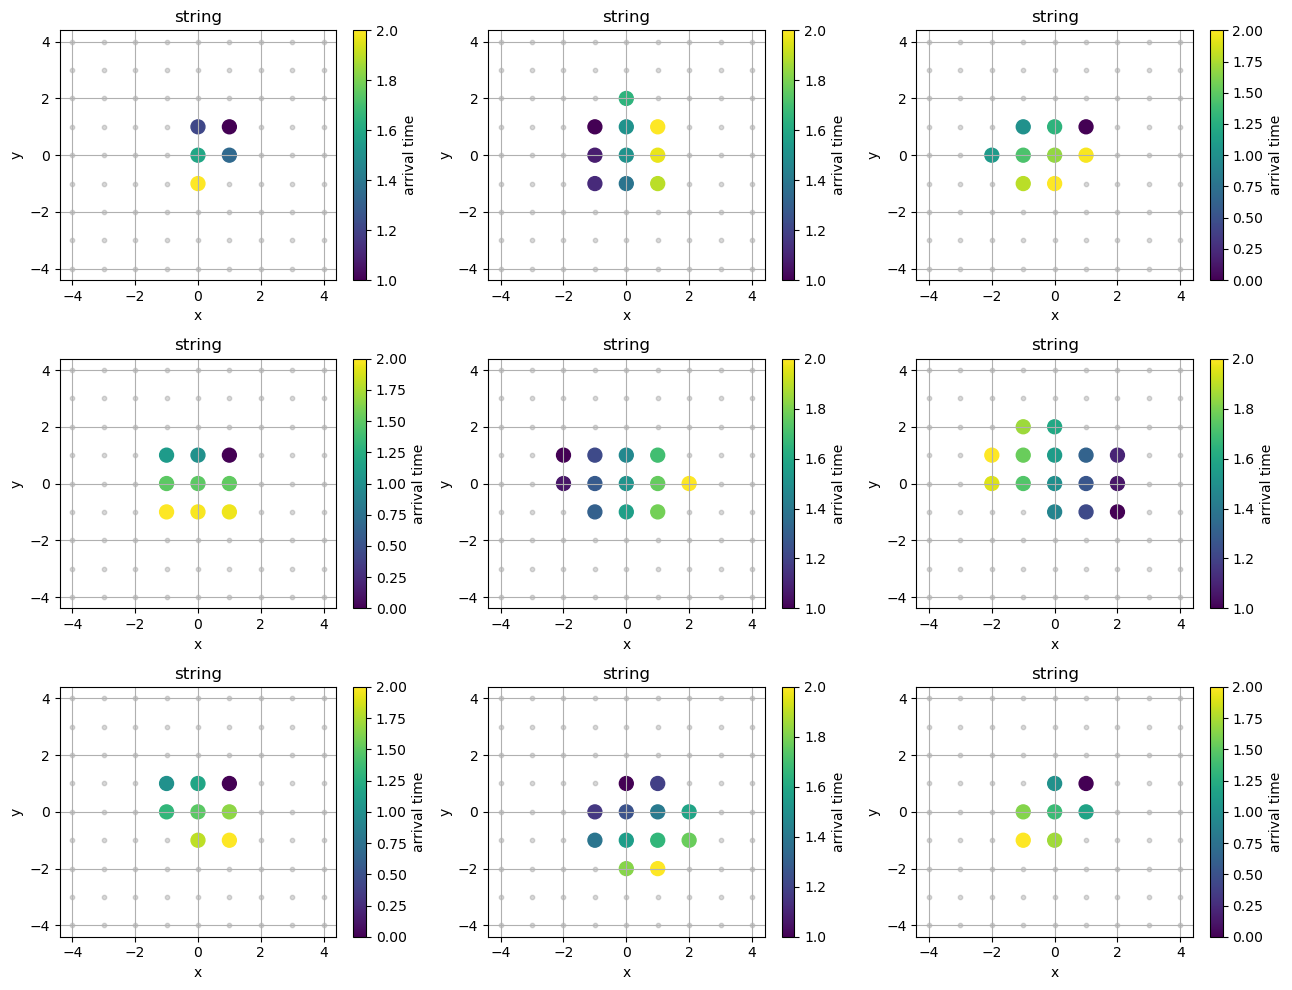

In [4]:
detectors_signals, arrival_times, logE, mass, xmax = du.get_data(True)

# arrival_times = du.proposedArrivalTimesNorm(arrival_times)
shower_maps = du.arrivalTimesDomMap(arrival_times)
shower_maps = shower_maps.reshape(-1, 1, 9, 9)
# total_signals = du.proposedTotalSignals(detectors_signals)

plot = du.plot_signals_arrival_times(arrival_times, N=3, random=True , show=True)

In [5]:
train_set = torch.from_numpy(shower_maps).type(torch.float32)
train_set = TensorDataset(train_set)

dataloader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

opt_disc = optim.Adam(disc_model.parameters(), lr=LEARNING_RATE)
opt_gen = optim.Adam(gen_model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

writer_fake = SummaryWriter(f"logs/GAN_EAS/fake")
writer_real = SummaryWriter(f"logs/GAN_EAS/real")
writer = SummaryWriter(f"logs/GAN_EAS/loses")

In [6]:
step = 0

disc_model.train()
gen_model.train()

for epoch in range(EPOCHS):
    start_time = time()
    for batch_idx, (real, ) in enumerate(dataloader):
        real = real.view(-1,9*9).to(device)
        batch_size = real.shape[0]

        ## Train discriminator: max log(D(real)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, LATENT_DIM).to(device)
        fake = gen_model(noise)
        disc_real = disc_model(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc_model(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc_model.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ## Train Generator min log(1 - D(G(z))) <---> max log(D(G(x)))
        output = disc_model(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen_model.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        tut.print_batches_progress_bar(batch_idx, len(dataloader))

        if batch_idx == 0:
            info_dict = {"disc_loss": lossD, "gen_loss": lossG}
            
            disc_model.eval()
            gen_model.eval()
            
            with torch.no_grad():
                fake = gen_model(fixed_noise).reshape(-1,1,9,9)
                data = real.reshape(-1, 1, 9, 9)

                fake = fake.cpu().numpy()
                data = data.cpu().numpy()

                fake_showers_fig = du.plot_signals_arrival_times(fake, N=3, random=True)
                real_showers_fig = du.plot_signals_arrival_times(data, N=3, random=True)

                writer_fake.add_figure("Fake showers", fake_showers_fig, global_step=step)
                writer_real.add_figure("Real showers", real_showers_fig, global_step=step)

                writer.add_scalar("Loss/Disc", lossD.cpu().item(), global_step=step )
                writer.add_scalar("Loss/Gen", lossG.cpu().item() , global_step=step )

            step += 1
            disc_model.train()
            gen_model.train()

                
    elapsed_time = time() - start_time
    info_dict["time"] = elapsed_time
    tut.print_epoch_info(epoch,EPOCHS,INFO_FREQ,info_dict)

[======================================================================>] 100%, batch 1563 	
------------------------------------------------------------------------------------
| Epoch: [001/010] | disc_loss: 0.6764 | gen_loss: 0.7046 | time: 5.72s | 
------------------------------------------------------------------------------------

[======================================================================>] 100%, batch 1563 	
------------------------------------------------------------------------------------
| Epoch: [003/010] | disc_loss: 0.5107 | gen_loss: 0.8440 | time: 4.99s | 
------------------------------------------------------------------------------------

[======================================================================>] 100%, batch 1563 	
------------------------------------------------------------------------------------
| Epoch: [005/010] | disc_loss: 0.6667 | gen_loss: 0.7460 | time: 4.90s | 
---------------------------------------------------------------------

In [8]:
%load_ext tensorboard
%tensorboard --logdir=logs/GAN_EAS

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 64408), started 0:00:01 ago. (Use '!kill 64408' to kill it.)